# Exploratory Analysis of Pitchers

This notebook explores pitcher statistics from the 2017 season. The goal here is to a) narrow down the list of pitchers to include in the analysis and b) examine the statistics that we'll be correlating with model performance. 

After getting set up, we'll take a look at the `pitchers` table from the database.

In [161]:
%load_ext autoreload
% autoreload 2
% matplotlib inline

import sys
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src/')
from utils.PitchDB import PitchDB
from preproc import pitchers

sns.set(style="ticks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
db = PitchDB()
df = db.query('select * from pitchers')
db.close()

In [91]:
pitcher_id_map = pd.read_csv('../data/id_map.csv', sep=',', encoding='latin-1')

In [92]:
print(df.columns)
df.head()

Index(['season', 'Name', 'Age', 'Level', 'Team', 'G', 'GS', 'W', 'L', 'SV',
       'IP', 'H', 'R', 'ER', 'uBB', 'BB', 'SO', 'HR', 'HBP', 'ERA', 'AB',
       'X1B', 'X2B', 'X3B', 'IBB', 'GDP', 'SF', 'SB', 'CS', 'PO', 'BF', 'Pit',
       'Str', 'StL', 'StS', 'GB.FB', 'LD', 'PU', 'WHIP', 'BAbip', 'SO9',
       'SO.W', 'SO_perc', 'uBB_perc', 'SO_uBB'],
      dtype='object')


,season,Name,Age,Level,Team,G,GS,W,L,SV,...,GB.FB,LD,PU,WHIP,BAbip,SO9,SO.W,SO_perc,uBB_perc,SO_uBB
0,2015,Clayton Kershaw,27.0,MLB-NL,Los Angeles,33.0,33.0,16.0,7.0,NaN,...,0.51,0.26,0.07,0.881,0.283,11.6,7.17,0.338,0.046,0.0
1,2015,Dallas Keuchel,27.0,MLB-AL,Houston,33.0,33.0,20.0,8.0,NaN,...,0.61,0.25,0.04,1.017,0.269,8.4,4.24,0.237,0.056,0.0
2,2015,Jake Arrieta,29.0,MLB-NL,Chicago,33.0,33.0,22.0,6.0,NaN,...,0.57,0.25,0.04,0.865,0.247,9.3,4.92,0.271,0.053,0.0
3,2015,Max Scherzer,30.0,MLB-NL,Washington,33.0,33.0,14.0,12.0,NaN,...,0.37,0.28,0.11,0.918,0.273,10.9,8.12,0.307,0.036,0.0
4,2015,Zack Greinke,31.0,MLB-NL,Los Angeles,32.0,32.0,19.0,3.0,NaN,...,0.48,0.28,0.07,0.844,0.232,8.1,5.00,0.237,0.046,0.0


So, we have plenty of data to work with (3 seasons) with a number of pitching statistics to choose from.

## Pitcher Selection

Here we'll determine the criteria for which pitchers to include in the analysis. First, we'll remove pitchers who are not present in both the training (2015 and/or 2016 seasons) and test (2017) data. So, for example, 2017 rookies are excluded. Then, we'll get a separate tally of innings pitched (IP) and batters faced (BF) for 2015/2016 and 2017 for each pitcher. Then, we'll drop pitchers who faced less than 100 batters combined in 2015 and 2016. This jus ensures that  This will give us a list of elligible pitchers to be used in the data. 

The last criteria is to select the top 8 pitchers, according to IP and BF, for each team in 2017. These 300 players will be used to correlate their 2017 pitching stats (e.g., opponent batting-average) with the results of model testing perfomance on their 2017 data.

In [245]:
# get only pitchers who are in both 2015 and/or 2016, and 2017

training_set_pitchers = np.unique(df[(df['season'] == '2015') | (df['season'] == '2016')]['Name'])
test_set_pitchers = np.unique(df[df['season'] == '2017']['Name'])

elligible_pitchers = [i for i in test_set_pitchers if i in training_set_pitchers]
df = df[df['Name'].isin(elligible_pitchers)]

In [246]:
df = df.sort_values(['season', 'IP', 'BF'], ascending=False)
df['original_team'] = df.apply(lambda x: pitchers.get_original(x['Team']), axis=1)
df['original_league'] = df.apply(lambda x: pitchers.get_original(x['Level']), axis=1)

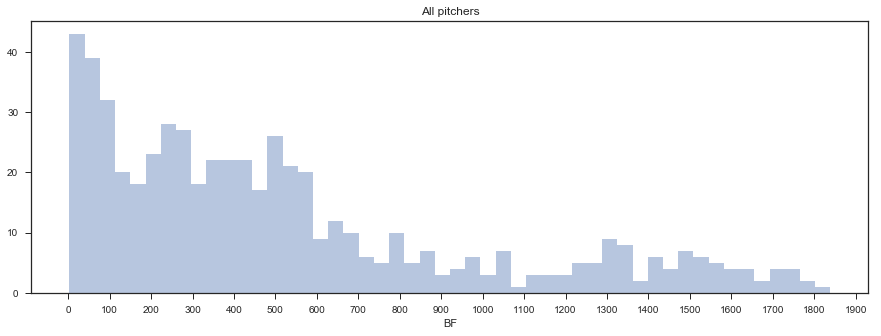

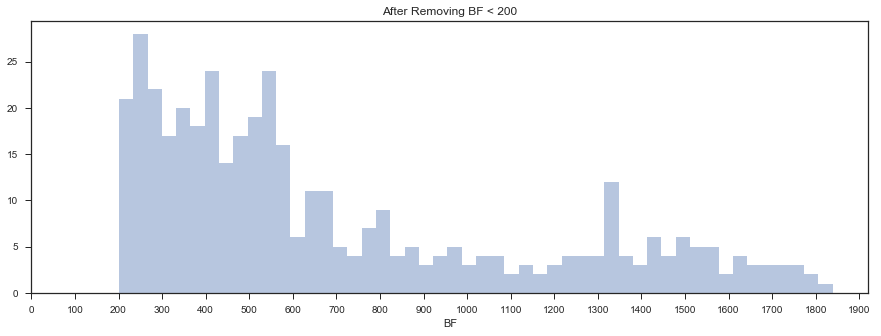

In [291]:
# get BF and IP for 2015/2016 and 2017 for each pitcher

numbers_per_season = df.sort_values(['Name', 'season'])[['Name', 'season', 'IP', 'BF']]

def sum_training_seasons(x):
    
    sums = x[(x['season'] == '2015') | (x['season'] == '2016')][['IP', 'BF']].apply(sum)
    return x.append(
        pd.DataFrame(
            {'Name': x.iloc[0]['Name'], 'season': '2015_2016', 'IP': sums['IP'], 'BF': sums['BF']},
            index=[0]
        )
    )
        
numbers_per_season = numbers_per_season.groupby('Name').apply(sum_training_seasons)
numbers_per_season = numbers_per_season[
    (numbers_per_season['season'] != '2015') & (numbers_per_season['season'] != '2016')
].reset_index(drop=True)



plt.figure(figsize=(15, 5))
sns.distplot(numbers_per_season[numbers_per_season['season'] == '2015_2016']['BF'], bins=50, kde=False)
plt.title('All pitchers')
plt.xticks(np.arange(0, 2000, 100))
plt.show()


# drop pitchers who faced less than 200 total batters in 2015/2016 
BF_threshold = 200

grouped = numbers_per_season.groupby('Name')
list_ = []
for name, g in grouped:
    if (g[g['season'] == '2015_2016']['BF'] >= BF_threshold).item():
        list_.append(g)
    else:
        continue

numbers_per_season = pd.concat(list_)

plt.figure(figsize=(15, 5))
sns.distplot(numbers_per_season[numbers_per_season['season'] == '2015_2016']['BF'], bins=50, kde=False)
plt.xticks(np.arange(0, 2000, 100))
plt.title('After Removing BF < {}'.format(BF_threshold))
plt.show()

# get top 8 pitchers in 2017 from each team
top_n = 8

numbers_2017 = (
    numbers_per_season[numbers_per_season['season'] == '2017']
    .merge(
        df[df['season'] == '2017'][['Name', 'original_team', 'original_league']],
        on='Name'
    )
    .sort_values(['IP', 'BF'], ascending=False)
)

top_pitchers = pitchers.get_top_pitchers(numbers_2017, groupby_key=('original_league', 'original_team'), n=top_n)

True


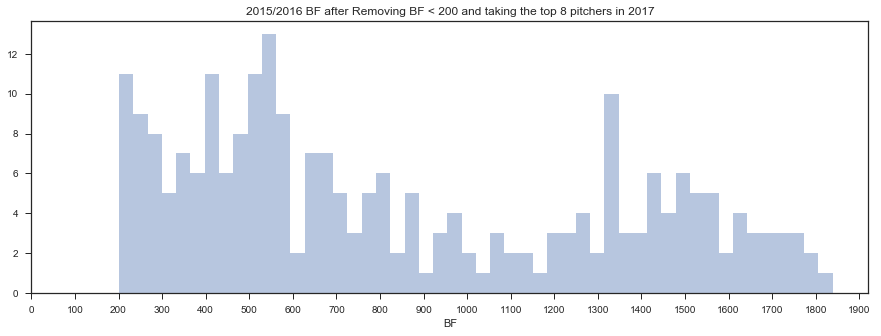

['A.J. Griffin' 'AJ Ramos' 'Aaron Nola' 'Adam Conley' 'Adam Morgan'
 'Adam Wainwright' 'Addison Reed' 'Alex Claudio' 'Alex Colome'
 'Alex Wilson' 'Alex Wood' 'Andrew Cashner' 'Andrew Triggs'
 'Anibal Sanchez' 'Archie Bradley' 'Ariel Miranda' 'Arodys Vizcaino'
 'Bartolo Colon' 'Blake Snell' 'Blake Treinen' 'Blake Wood' 'Brad Brach'
 'Brad Hand' 'Brandon Kintzler' 'Brandon Maurer' 'Brandon McCarthy'
 'Brett Cecil' 'Brian Duensing' 'Bryan Shaw' 'Bud Norris' 'CC Sabathia'
 'Carlos Carrasco' 'Carlos Martinez' 'Carlos Rodon' 'Carlos Torres'
 'Chad Kuhl' 'Charlie Morton' 'Chase Anderson' 'Chris Archer'
 'Chris Devenski' 'Chris Hatcher' 'Chris Rusin' 'Chris Sale'
 'Chris Tillman' 'Christian Bergman' 'Clayton Kershaw' 'Clayton Richard'
 'Cody Allen' 'Cody Reed' 'Cole Hamels' 'Collin McHugh' 'Corey Kluber'
 'Corey Knebel' 'Cory Gearrin' 'Dallas Keuchel' 'Dan Jennings'
 'Dan Straily' 'Daniel Norris' 'Danny Duffy' 'Danny Salazar' 'David Price'
 'David Robertson' 'Dellin Betances' 'Derek Holland' '

In [295]:
selected_pitchers = top_pitchers['Name']

# ensure that all pitchers are unique
print(all(top_pitchers.Name.unique() == top_pitchers.Name.values))

shortlist = numbers_per_season[numbers_per_season['Name'].isin(selected_pitchers)]

plt.figure(figsize=(15, 5))
sns.distplot(shortlist[shortlist['season'] == '2015_2016']['BF'], bins=50, kde=False)
plt.xticks(np.arange(0, 2000, 100))
plt.title('2015/2016 BF after Removing BF < {} and taking the top {} pitchers in 2017'.format(BF_threshold, top_n))
plt.show()


# show pitchers
print(np.unique(shortlist['Name']))

...

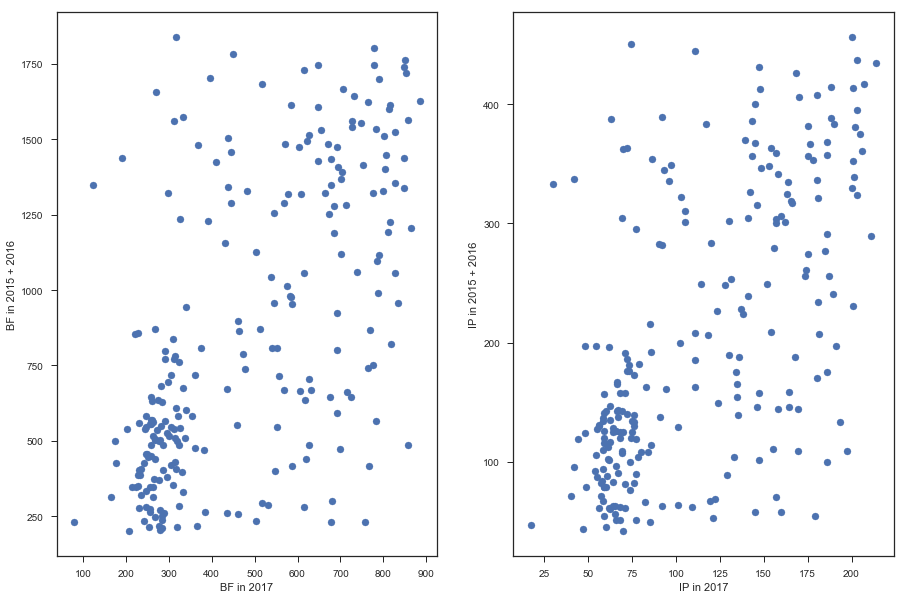

In [279]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(
    shortlist[shortlist['season'] == '2017']['BF'],
    shortlist[shortlist['season'] == '2015_2016']['BF']
)
plt.xlabel('BF in 2017')
plt.ylabel('BF in 2015 + 2016')
plt.subplot(1, 2, 2)
plt.scatter(
    shortlist[shortlist['season'] == '2017']['IP'],
    shortlist[shortlist['season'] == '2015_2016']['IP']
)
plt.xlabel('IP in 2017')
plt.ylabel('IP in 2015 + 2016')

...

In [296]:
# make shortlisted 2017 dataframe

df_2017 = df[df['season'] == '2017']
df_2017 = df_2017[df_2017['Name'].isin(selected_pitchers)]

In [297]:
def plot_pitchers(x):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.distplot(x.IP, kde=False, bins=30)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.distplot(x.BF, kde=False, bins=30)
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.scatter(x.GS, x.IP)
    plt.xlabel('Game Starts')
    plt.ylabel('Innings Pitched')
    plt.subplot(1, 3, 2)
    plt.scatter(x.GS, x.BF)
    plt.xlabel('Game Starts')
    plt.ylabel('Batters Faced')
    plt.subplot(1, 3, 3)
    plt.scatter(x.GS, x.G)
    plt.xlabel('Game Starts')
    plt.ylabel('Games Played')
    plt.show()

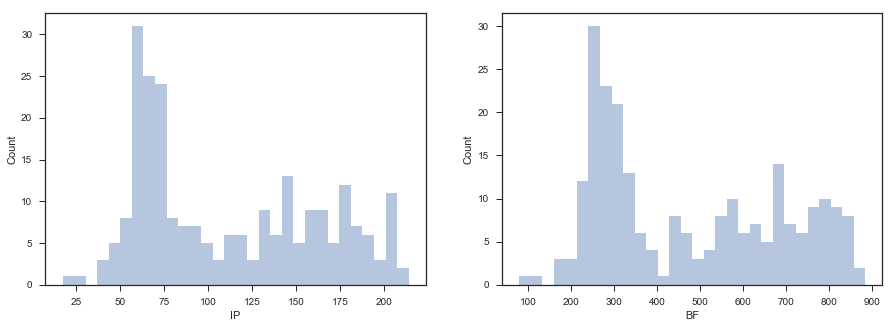

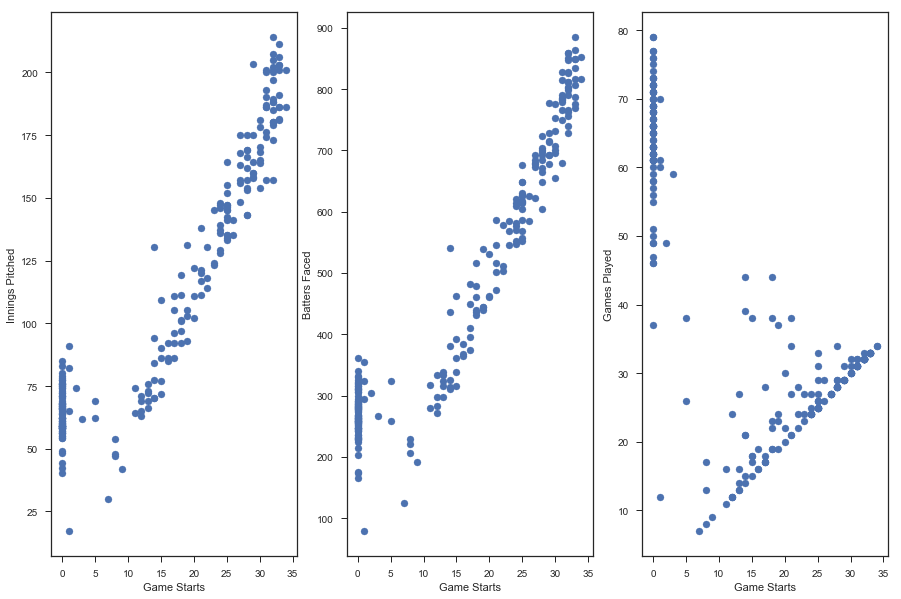

In [298]:
plot_pitchers(df_2017)

..

## Opponent OBP and BA

Now that we hav

In [299]:
df_2017['OBA'] = pitchers.OBA(df_2017)
df_2017['OOBP'] = pitchers.OOBP(df_2017)

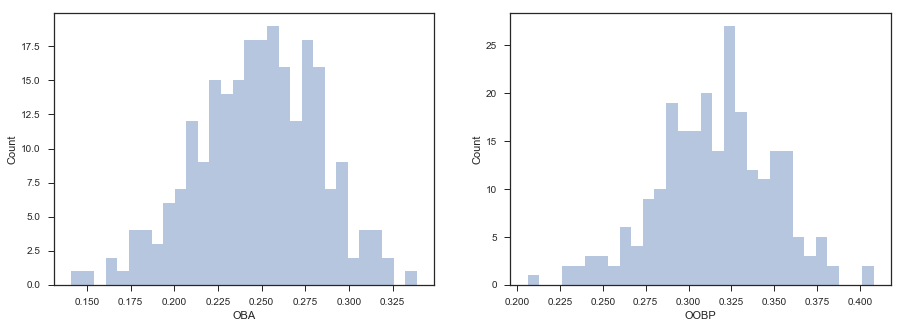

In [300]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(df_2017.OBA, kde=False, bins=30)
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.distplot(df_2017.OOBP, kde=False, bins=30)
plt.ylabel('Count')

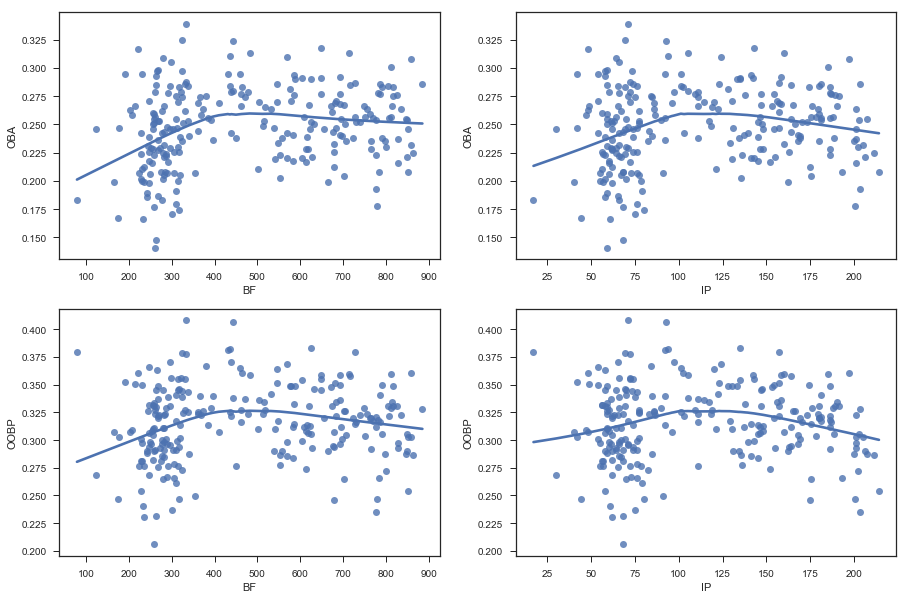

In [301]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.regplot(df_2017['BF'], df_2017['OBA'], lowess=True)
plt.subplot(2, 2, 2)
sns.regplot(df_2017['IP'], df_2017['OBA'], lowess=True)
plt.subplot(2, 2, 3)
sns.regplot(df_2017['BF'], df_2017['OOBP'], lowess=True)
plt.subplot(2, 2, 4)
sns.regplot(df_2017['IP'], df_2017['OOBP'], lowess=True)

...

In [302]:
# Note that this merge produces duplicates of two players due to having more than one MLB id
final = df_2017.merge(pitcher_id_map[['bref_name', 'mlb_id']], left_on='Name', right_on='bref_name').drop('bref_name', axis=1)

final.head()

,season,Name,Age,Level,Team,G,GS,W,L,SV,...,SO9,SO.W,SO_perc,uBB_perc,SO_uBB,original_team,original_league,OBA,OOBP,mlb_id
0,2017,Chris Sale,28.0,MLB-AL,Boston,32.0,32.0,17.0,8.0,NaN,...,12.9,7.16,0.362,0.051,0.0,Boston,MLB-AL,0.208,0.254417,519242
1,2017,Ervin Santana,34.0,MLB-AL,Minnesota,33.0,33.0,16.0,8.0,NaN,...,7.1,2.74,0.193,0.068,0.0,Minnesota,MLB-AL,0.225,0.286380,429722
2,2017,Jeff Samardzija,32.0,MLB-NL,San Francisco,32.0,32.0,9.0,15.0,NaN,...,8.9,6.41,0.242,0.037,0.0,San Francisco,MLB-NL,0.255,0.287070,502188
3,2017,Justin Verlander,34.0,MLB-AL,"Detroit,Houston",33.0,33.0,15.0,8.0,NaN,...,9.6,3.04,0.258,0.080,0.0,Detroit,MLB-AL,0.221,0.290094,434378
4,2017,Carlos Martinez,25.0,MLB-NL,St. Louis,32.0,32.0,12.0,11.0,NaN,...,9.5,3.06,0.253,0.079,0.0,St. Louis,MLB-NL,0.232,0.302462,593372


In [198]:
final.to_csv('../data/pitcher_stats.csv', sep=',')